<a href="https://colab.research.google.com/github/Abre1234/Customer-Churn-Prediction-/blob/main/notebooks/Customer_Churn_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Customer Churn Prediction Project

#Import Necessary Libraries

In [55]:

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Train-test split
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#!pip install xgboost lightgbm catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

#Load Dataset

In [32]:

# Define file path
path = "/content/drive/MyDrive/Projects /Churn prediction/Churn.csv"

# Load dataset
df = pd.read_csv(path)

# Show first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#EDA

In [33]:

# Check shape (rows, columns)
print("Dataset shape:", df.shape)

# Check column names
print("\nColumns:\n", df.columns)

# Check basic info
print("\nDataset info:")
df.info()

Dataset shape: (7043, 21)

Columns:
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null 

In [34]:

# Sometimes TotalCharges has empty strings
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df = df.dropna()

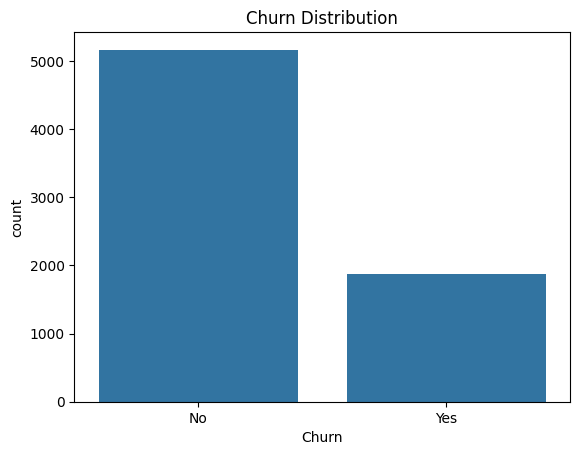

Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [35]:

# Count of churn vs non-churn
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

print(df['Churn'].value_counts(normalize=True)*100)

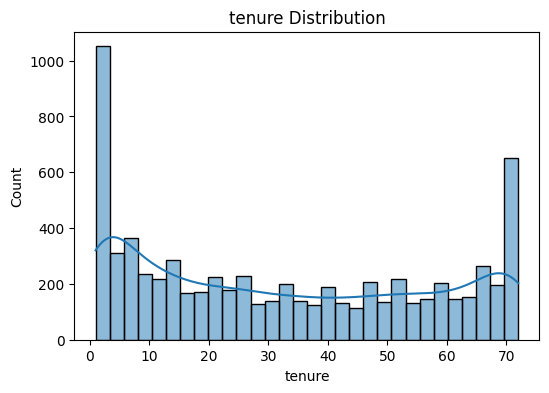

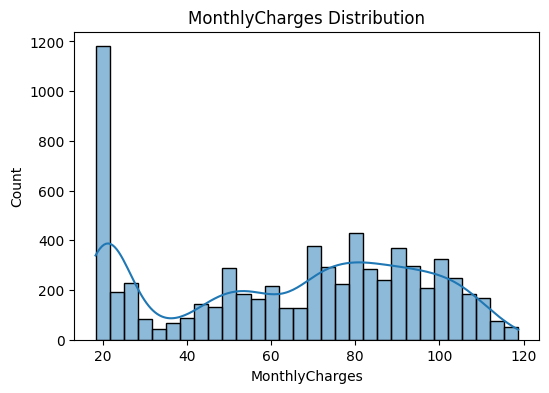

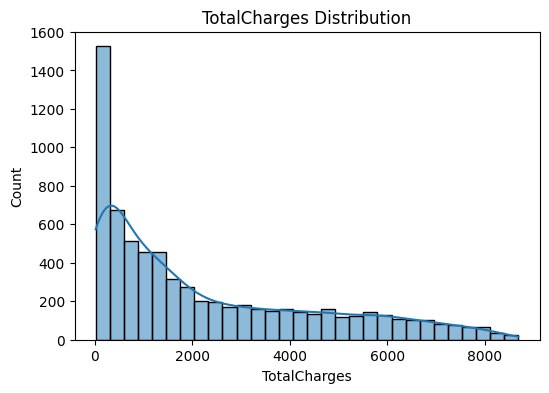

In [36]:

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Distribution plots
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col} Distribution")
    plt.show()

Categorical Analysis

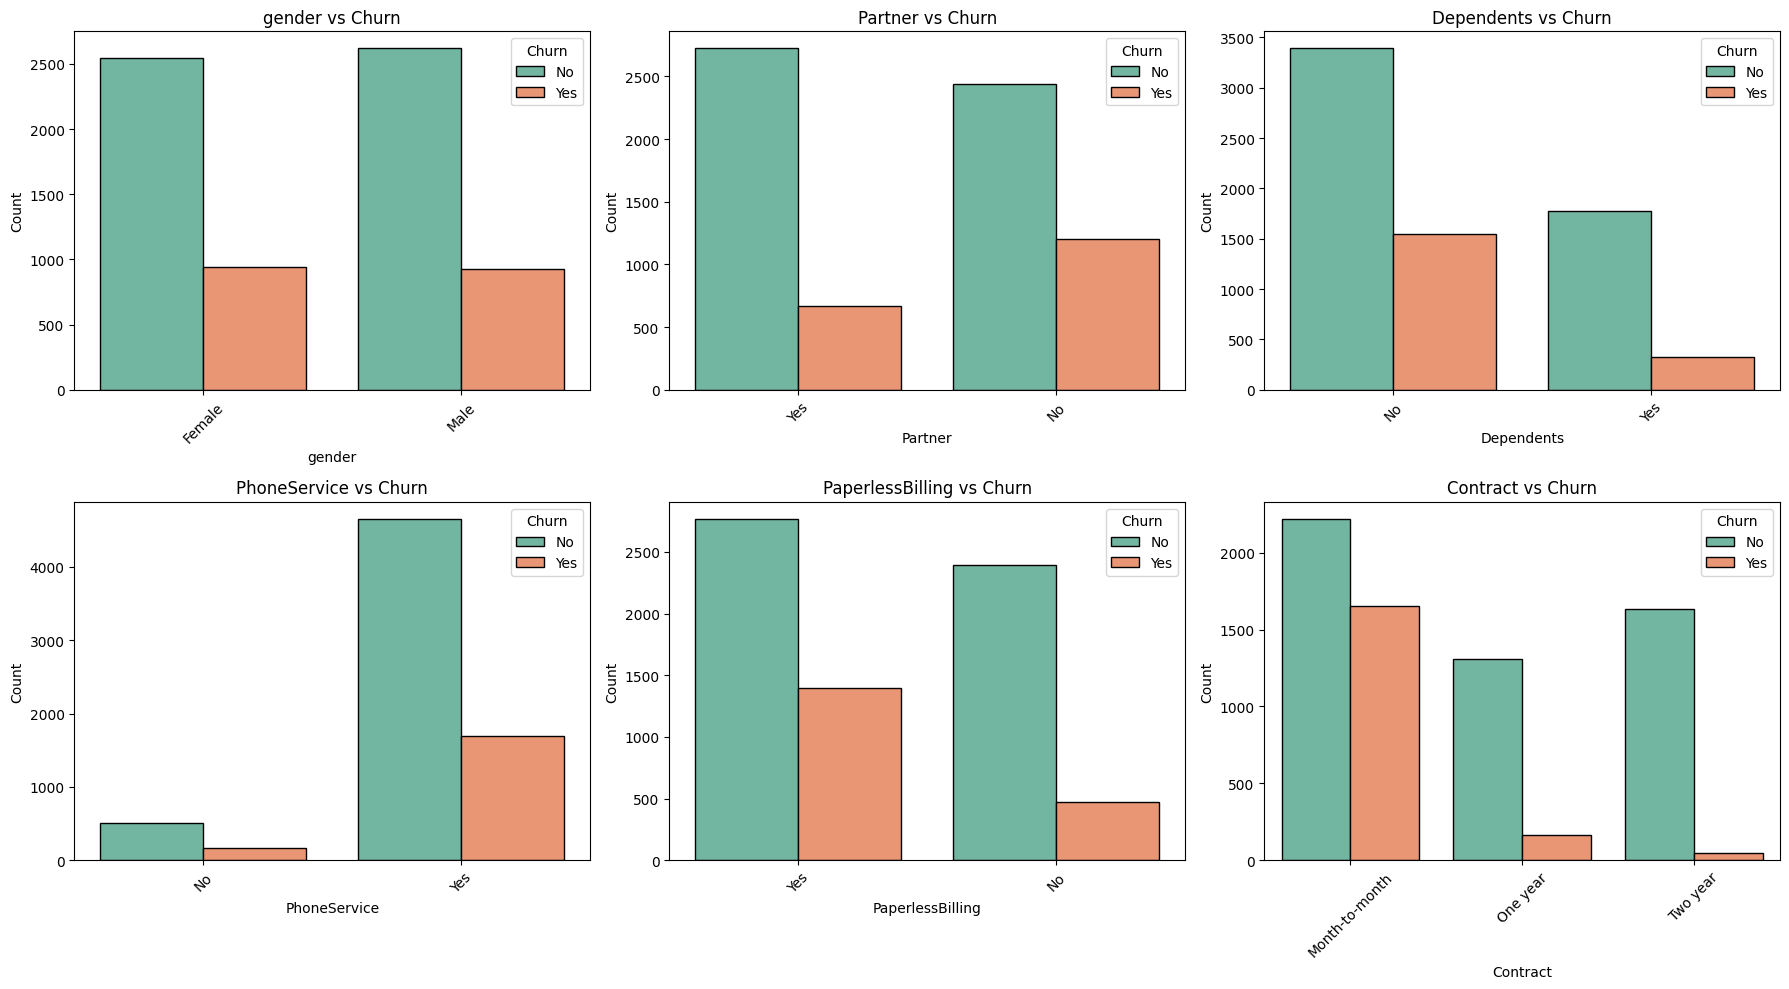

In [37]:

# Select 6 categorical columns for 2x3 grid
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Contract']

# Create 2 rows x 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18,10))  # 2 rows, 3 columns
axes = axes.flatten()  # flatten to iterate easily

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Churn', data=df, palette='Set2', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"{col} vs Churn")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#Data Cleaning & Preprocessing

In [38]:

# Drop customerID
df = df.drop('customerID', axis=1)

Encode categorical variables

In [39]:

# Binary columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    df[col] = df[col].map({'Yes':1, 'No':0})

# Gender
df['gender'] = df['gender'].map({'Male':1, 'Female':0})

# Multi-category columns
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

#Feature & Target split

In [40]:

# Target
y = df['Churn']

# Features
X = df.drop('Churn', axis=1)

Feature scaling

In [41]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train-Test Split

In [42]:


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 5625
Testing samples: 1407


Apply SMOTE

In [43]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_smote.value_counts())

After SMOTE:
Churn
0    4130
1    4130
Name: count, dtype: int64


Visualize Before and After SMOTE

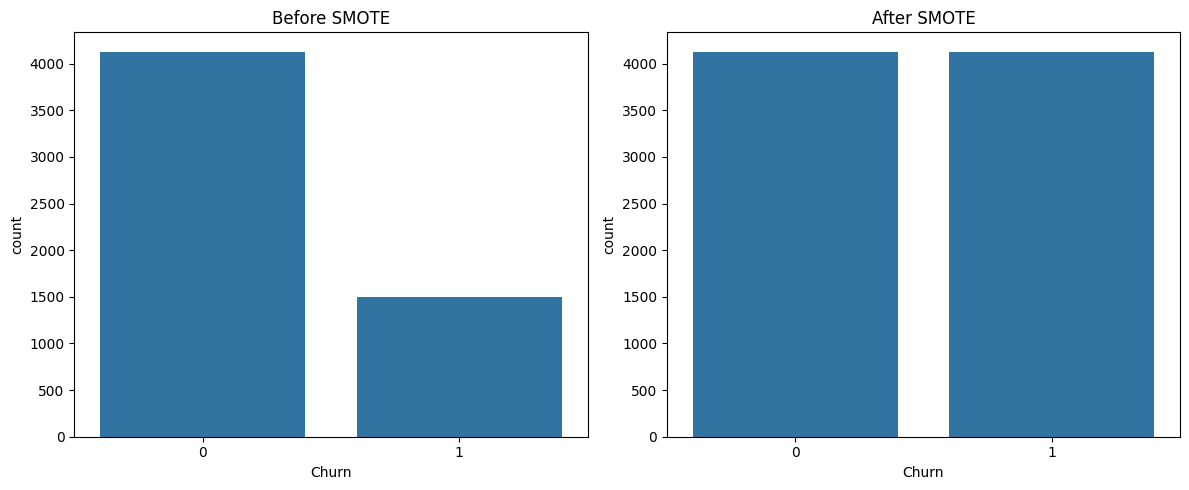

In [44]:

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Before SMOTE")

# After SMOTE
sns.countplot(x=y_train_smote, ax=axes[1])
axes[1].set_title("After SMOTE")

plt.tight_layout()
plt.show()

#Train model

Train Logistics Regression

Logistic Regression outputs probabilities

In [59]:

# Train model
lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train, y_train)

# Predict probabilities (sigmoid output)
y_prob = lr.predict_proba(X_test)[:,1]  # Probability of class 1 (Churn)

Apply customer threshold

In [68]:

# Default threshold 0.5
y_pred_05 = (y_prob >= 0.5).astype(int)

# Custom threshold 0.4
y_pred_04 = (y_prob >= 0.4).astype(int)

# Optional: threshold 0.3
y_pred_03 = (y_prob >= 0.3).astype(int)

#Evaluation

In [69]:

from sklearn.metrics import classification_report

print("Classification Report - Threshold 0.5")
print(classification_report(y_test, y_pred_05))

print("Classification Report - Threshold 0.4")
print(classification_report(y_test, y_pred_04))

Classification Report - Threshold 0.5
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

Classification Report - Threshold 0.4
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1033
           1       0.58      0.68      0.63       374

    accuracy                           0.78      1407
   macro avg       0.73      0.75      0.74      1407
weighted avg       0.80      0.78      0.79      1407



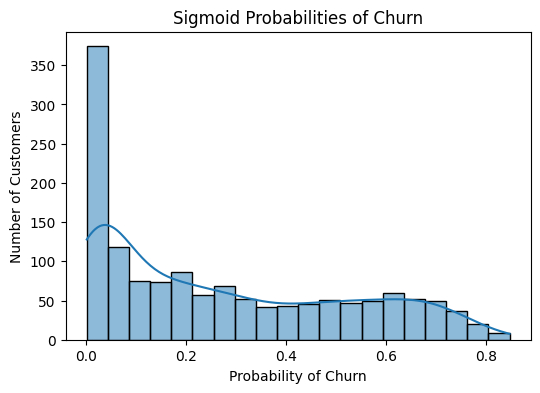

In [71]:

plt.figure(figsize=(6,4))
sns.histplot(y_prob, bins=20, kde=True)
plt.xlabel("Probability of Churn")
plt.ylabel("Number of Customers")
plt.title("Sigmoid Probabilities of Churn")
plt.show()

Plot Recall vs Threshold

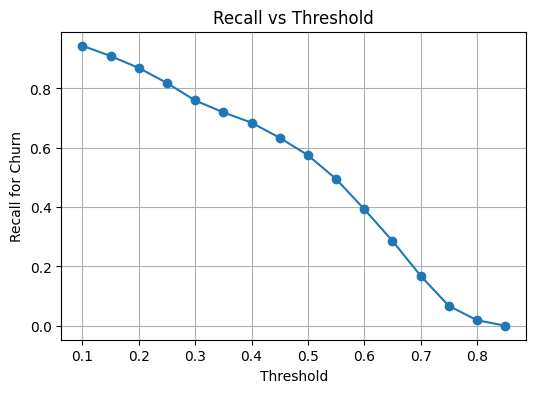

In [72]:

thresholds = np.arange(0.1, 0.9, 0.05)
recalls = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_t))

plt.figure(figsize=(6,4))
plt.plot(thresholds, recalls, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Recall for Churn")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.show()

ROC Curve & AUC

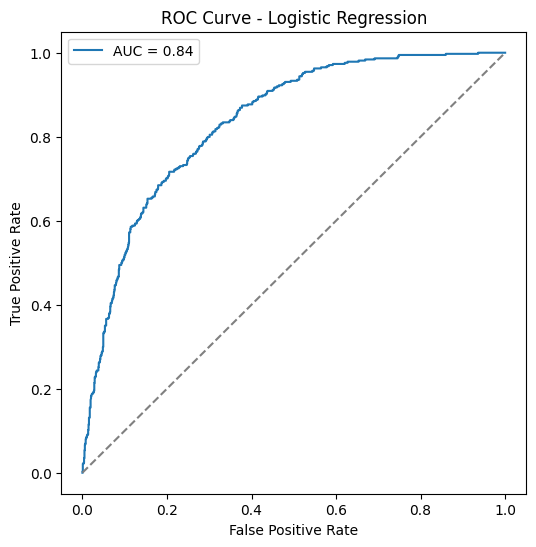

In [73]:

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In [74]:

import joblib

# Save model
joblib.dump(lr, "logistic_churn_model.pkl")

['logistic_churn_model.pkl']